# 43B-modeling-ARIMA-backward-forecast

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pmdarima as pm

import os

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import ADFTest
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score

In [2]:
#Constants/globals
os.chdir('/data/p_dsi/teams2023/team9/')
os.getcwd()

'/gpfs52/data/p_dsi/teams2023/team9'

In [3]:
#load the data
data = pd.read_csv("Asurion_clean_data_feature_set.csv")
display(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   phone model       11684 non-null  object
 1   phone size        11684 non-null  object
 2   phone color       11684 non-null  object
 3   claim             11684 non-null  int64 
 4   weeks_monday      11684 non-null  object
 5   month             11684 non-null  object
 6   year              11684 non-null  int64 
 7   season            11684 non-null  object
 8   quarter           11684 non-null  object
 9   Holidays_Boolean  11684 non-null  bool  
 10  company           11684 non-null  object
 11  model_group       11684 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 1015.6+ KB


None

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company,model_group
0,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
1,apple iphone 11,128gb,green,45,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
2,apple iphone 11,128gb,purple,92,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
3,apple iphone 11,128gb,red,69,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
4,apple iphone 11,128gb,white,91,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
5,apple iphone 11,128gb,yellow,5,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
6,apple iphone 11,256gb,black,24,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
7,apple iphone 11,256gb,green,3,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
8,apple iphone 11,256gb,purple,7,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
9,apple iphone 11,256gb,red,9,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11


In [4]:
group_model = data.groupby('model_group')
group_model.first()

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company
model_group,,,,,,,,,,,
iphone 11,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple
iphone 12,apple iphone 12,128gb,black,68,2022-01-24,January,2022,winter,Q1,False,apple
iphone 13,apple iphone 13,128gb,midnight,11,2022-01-24,January,2022,winter,Q1,False,apple
iphone 14,apple iphone 14,128gb,black,7,2022-11-14,November,2022,autumn,Q4,False,apple
iphone se,apple iphone se,128gb,gray,1,2022-01-24,January,2022,winter,Q1,False,apple
iphone x,apple iphone x,256gb,gray,62,2022-01-24,January,2022,winter,Q1,False,apple


Text(0.5, 1.0, 'iPhone 14')

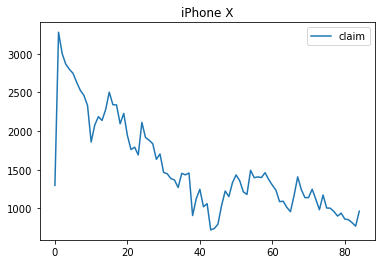

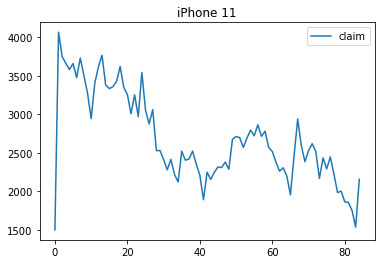

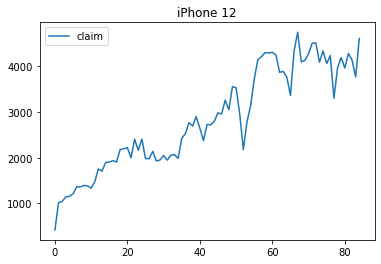

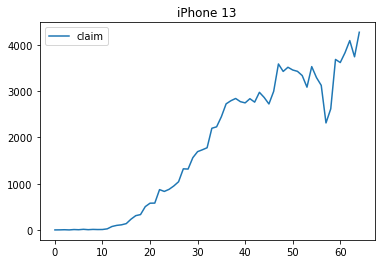

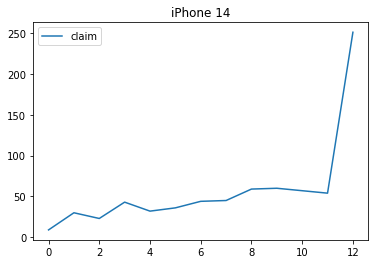

In [5]:
# As discussed with professor, removing the last row of aggregate data since it looks like their incomplete data, this is
# applied to all models 

# Skipping SE as it goes too far back

iphonex = data[data["model_group"] == "iphone x"]
result_iphone_x = iphonex.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_x = result_iphone_x[:-1]

iphone11 = data[data["model_group"] == "iphone 11"]
result_iphone_11 = iphone11.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_11 = result_iphone_11[:-1]

iphone12 = data[data["model_group"] == "iphone 12"]
result_iphone_12 = iphone12.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_12 = result_iphone_12[:-1]

iphone13 = data[data["model_group"] == "iphone 13"]
result_iphone_13 = iphone13.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_13 = result_iphone_13[:65]

iphone14 = data[data["model_group"] == "iphone 14"]
result_iphone_14 = iphone14.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_14 = result_iphone_14[:-1]

result_iphone_x.plot()
plt.title("iPhone X")
result_iphone_11.plot()
plt.title("iPhone 11")
result_iphone_12.plot()
plt.title("iPhone 12")
result_iphone_13.plot()
plt.title("iPhone 13")
result_iphone_14.plot()
plt.title("iPhone 14")

In [6]:
# Making a copy just in case before I start reversing data

result_iphone_x_copy = result_iphone_x.copy()
result_iphone_11_copy = result_iphone_11.copy()
result_iphone_12_copy = result_iphone_12.copy()
result_iphone_13_copy = result_iphone_13.copy()
result_iphone_14_copy = result_iphone_14.copy()

## iPhone X

,weeks_monday,claim
0,2023-02-06,964
1,2023-01-30,770
2,2023-01-23,815
3,2023-01-16,853
4,2023-01-09,862
...,...,...
80,2021-07-26,2800
81,2021-07-19,2866
82,2021-07-12,3004
83,2021-07-05,3280


Text(0.5, 1.0, 'iPhone X Reversed')

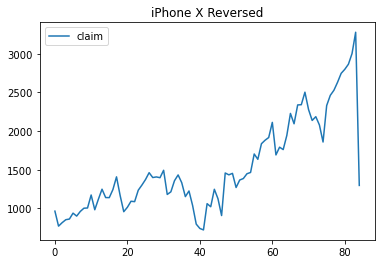

In [7]:
reverse_iphone_x = result_iphone_x_copy.iloc[::-1].reset_index(drop=True)

display(reverse_iphone_x)

reverse_iphone_x.plot()
plt.title("iPhone X Reversed")

# Earliest data point is 6/28/2021
# Need to jump back to November 3, 2017 to December, 2017 to be generally reasonable

In [8]:
train_x = reverse_iphone_x['claim'] 

# Taking all of the data to train so that the model can hopefully know it's in decline on the model reverse

arima_model_x = pm.auto_arima(train_x,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5, max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5, max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True, stepwise=True,
          random_state=20, n_fits=50)

arima_model_x.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1043.579, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1036.508, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1032.106, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1034.071, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1033.499, Time=0.29 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1033.476, Time=0.62 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1033.451, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1035.450, Time=0.76 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1038.558, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1034.075, Time=0.30 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1034.073, Time=0.28 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1035.016, Time=0.23 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1035.304, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1034.094, Time=0.33 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   85
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -513.053
Date:                            Wed, 29 Mar 2023   AIC                           1032.106
Time:                                    01:23:10   BIC                           1038.936
Sample:                                         0   HQIC                          1034.826
                                             - 85                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5439      0.180     -3.026      0.002      -0.896      -0.192
ma.S.L12      -0.4137      0.308     -1.344      0.179      -1.017       0.189
sigma2      8.801e+04   1.06e+04      8.342      0.000    6.73e+04    1.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               982.54
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               8.11   Skew:                            -3.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,predicted_values
85,2125.751591
86,1995.740076
87,2263.722974
88,2386.051426
89,2500.693686
...,...
258,4712.146442
259,4854.897232
260,4889.778215
261,4986.084659


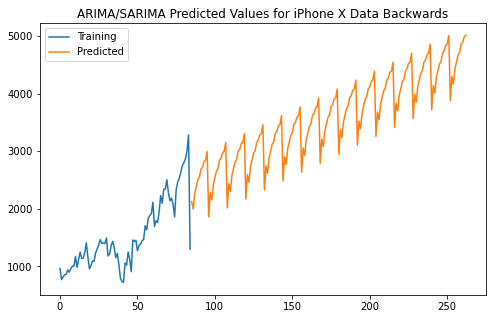

,predicted_values
85,2125.751591
86,1995.740076
87,2263.722974
88,2386.051426
89,2500.693686
...,...
258,4712.146442
259,4854.897232
260,4889.778215
261,4986.084659


In [9]:
prediction_x = pd.DataFrame(arima_model_x.predict(n_periods = 178))
prediction_x.columns = ['predicted_values']
display(prediction_x)

plt.figure(figsize=(8,5))
plt.plot(train_x,label="Training")
plt.plot(prediction_x,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA/SARIMA Predicted Values for iPhone X Data Backwards")
plt.show()

display(prediction_x)

# Model predicted an increasing trend when going backwards in time because our iPhone X data is in the declining stage
# Due to limited data with knowing about an iPhone's product cycle, the data is already past it's vertex, so the model doesn't
# know that the vertex has already passed, so it'll assume that the backwards data is trending upwards.
# Thus, I excluded iPhone X from the calcualtions below.

## iPhone 11

,weeks_monday,claim
0,2023-02-06,2157
1,2023-01-30,1536
2,2023-01-23,1751
3,2023-01-16,1856
4,2023-01-09,1863
...,...,...
80,2021-07-26,3583
81,2021-07-19,3664
82,2021-07-12,3753
83,2021-07-05,4068


Text(0.5, 1.0, 'iPhone 11 Reversed')

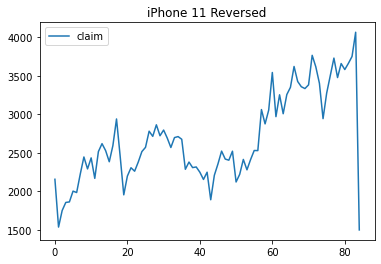

In [10]:
reverse_iphone_11 = result_iphone_11_copy.iloc[::-1].reset_index(drop=True)

display(reverse_iphone_11)

reverse_iphone_11.plot()
plt.title("iPhone 11 Reversed")

In [11]:
train_11 = reverse_iphone_11['claim']
# Taking all of the data to train so that the model can hopefully know it's in decline on the model reverse

arima_model_11 = pm.auto_arima(train_11,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5, max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5, max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True, stepwise=True,
          random_state=20, n_fits=50)

arima_model_11.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1083.892, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1079.304, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1075.127, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1078.088, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1076.605, Time=0.29 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1075.973, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1078.381, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1077.763, Time=0.77 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1080.195, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1076.974, Time=0.28 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1076.915, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1076.139, Time=0.21 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1078.772, Time=0.51 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1076.328, Time=0.36 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   85
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -534.564
Date:                            Wed, 29 Mar 2023   AIC                           1075.127
Time:                                    01:23:15   BIC                           1081.957
Sample:                                         0   HQIC                          1077.846
                                             - 85                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4659      0.256     -1.819      0.069      -0.968       0.036
ma.S.L12      -0.5498      0.316     -1.739      0.082      -1.169       0.070
sigma2      1.572e+05   9048.553     17.375      0.000    1.39e+05    1.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1457.57
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                            -3.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,predicted_values
85,2464.953805
86,2278.975258
87,2377.254576
88,2575.012239
89,2680.468414
...,...
164,1221.359918
165,1341.560225
166,1382.671924
167,1632.263583


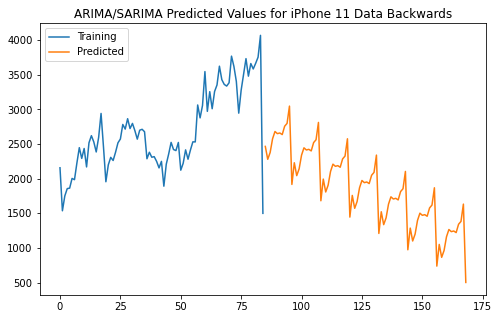

In [12]:
prediction_11 = pd.DataFrame(arima_model_11.predict(n_periods = 84))
prediction_11.columns = ['predicted_values']

display(prediction_11)

plt.figure(figsize=(8,5))
plt.plot(train_11,label="Training")
plt.plot(prediction_11,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA/SARIMA Predicted Values for iPhone 11 Data Backwards")
plt.show()

# iPhone 11 release was September 20, 2019, and it is reasonable it takes a month for first few phone claims to roll in
# Row 84 is representing 6/28/2021 data values
# Forecasted backwards to Monday, November 18, 2019
# Due to the model prediction, it does not make sense to further roll the data back due to the spike and limitiation with iPhone
# 11's true release date. The lowest value is about 501 iPhone 11 claims on index 168

## iPhone 12

,weeks_monday,claim
0,2023-02-06,4604
1,2023-01-30,3764
2,2023-01-23,4136
3,2023-01-16,4277
4,2023-01-09,3959
...,...,...
80,2021-07-26,1157
81,2021-07-19,1144
82,2021-07-12,1045
83,2021-07-05,1017


Text(0.5, 1.0, 'iPhone 12 Reversed')

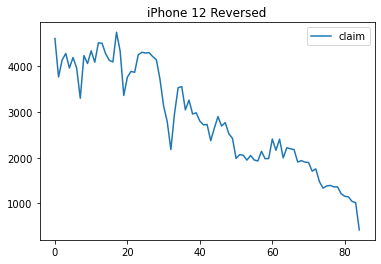

In [13]:
reverse_iphone_12 = result_iphone_12_copy.iloc[::-1].reset_index(drop=True)

display(reverse_iphone_12)

reverse_iphone_12.plot()
plt.title("iPhone 12 Reversed")

In [14]:
train_12 = reverse_iphone_12['claim']

# Taking all of the data to train so that the model can hopefully know it's in decline on the model reverse

arima_model_12 = pm.auto_arima(train_12,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5, max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5, max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True, stepwise=True,
          random_state=20, n_fits=50)

arima_model_12.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1068.934, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1058.397, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1050.470, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1062.588, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1051.448, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1051.059, Time=0.57 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1057.082, Time=0.19 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1052.756, Time=1.59 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1052.274, Time=0.31 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1052.422, Time=0.28 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1051.426, Time=0.25 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1053.643, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1051.349, Time=0.36 sec

Best model:  ARIMA(0,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   85
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -522.235
Date:                            Wed, 29 Mar 2023   AIC                           1050.470
Time:                                    01:23:20   BIC                           1057.300
Sample:                                         0   HQIC                          1053.189
                                             - 85                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3765      0.125     -3.022      0.003      -0.621      -0.132
ma.S.L12      -0.6221      0.148     -4.194      0.000      -0.913      -0.331
sigma2      1.081e+05    1.6e+04      6.735      0.000    7.66e+04     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.87
Prob(Q):                              1.00   Prob(JB):                         0.14
Heteroskedasticity (H):               0.27   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,predicted_values
85,493.555726
86,407.253254
87,336.486424
88,357.196190
89,325.776787
90,275.733313
91,20.443543
92,40.972593
93,131.452240
94,92.554650


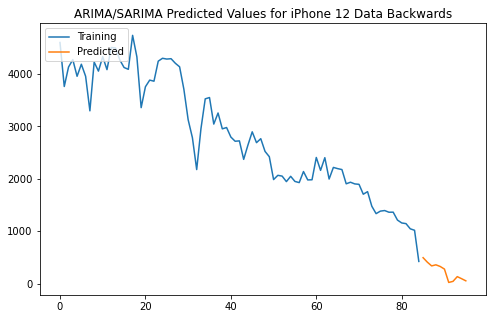

In [15]:
prediction_12 = pd.DataFrame(arima_model_12.predict(n_periods = 11))
prediction_12.columns = ['predicted_values']
display(prediction_12)


plt.figure(figsize=(8,5))
plt.plot(train_12,label="Training")
plt.plot(prediction_12,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA/SARIMA Predicted Values for iPhone 12 Data Backwards")
plt.show()

# iPhone 12 release was October 23, 2020, and it is reasonable it takes a month for first few phone orders to arrive
# Forecasted the data back to around Monday, April 12, 2021 as it became unreasonable to go further as the iPhone 12 claims
# became negative. I was only able to roll it back by 11 weeks before June 28, 2021
# Current lowest value is about 51 on index 95

# Weighted Average Model

Based on the forecasts created backwards, it is only reasonable to use 11, 12 as additional completed datasets.

This will give me 11, 12, and 13 as completed datasets to do further modelling techniques.

In [16]:
result_iphone_14_copy

,weeks_monday,claim
0,2022-11-14,9
1,2022-11-21,30
2,2022-11-28,23
3,2022-12-05,43
4,2022-12-12,32
5,2022-12-19,36
6,2022-12-26,44
7,2023-01-02,45
8,2023-01-09,59
9,2023-01-16,60


In [17]:
reordered_iphone_12 = reverse_iphone_12.iloc[::-1][:2].reset_index(drop=True).drop(['weeks_monday'], axis=1)

reordered_prediction_12 = prediction_12.iloc[::-1].reset_index(drop=True).rename(columns={'predicted_values': 'claim'})

reordered_prediction_12['claim'] = reordered_prediction_12['claim'].round(decimals = 0)

frames = [reordered_prediction_12, reordered_iphone_12]

iphone_12_final = pd.concat(frames).reset_index(drop=True).rename(columns={'claim': 'claim_12'})

# iphone_12_final is the final dataset with the first 13 values of life cycle put together
iphone_12_final

,claim_12
0,52.0
1,93.0
2,131.0
3,41.0
4,20.0
5,276.0
6,326.0
7,357.0
8,336.0
9,407.0


In [18]:
iphone_11_final = prediction_11[-13:].iloc[::-1].reset_index(drop=True).rename(columns={'predicted_values': 'claim'})

iphone_11_final['claim'] = iphone_11_final['claim'].round(decimals = 0)
# iphone_11_final is the final dataset with the first 13 values of life cycle from forecast value
iphone_11_final = iphone_11_final.rename(columns={'claim': 'claim_11'})
display(iphone_11_final)

iphone_13_final = result_iphone_13_copy[:13].drop(['weeks_monday'], axis=1).rename(columns={'claim': 'claim_13'})

display(iphone_13_final)

,claim_11
0,502.0
1,1632.0
2,1383.0
3,1342.0
4,1221.0
5,1244.0
6,1235.0
7,1266.0
8,1160.0
9,963.0


,claim_13
0,2
1,3
2,6
3,2
4,10
5,6
6,15
7,7
8,13
9,10


In [19]:
frames_final = [iphone_11_final, iphone_12_final, iphone_13_final]

final_group = pd.concat(frames_final, axis = 1)

display(final_group)

final_group['weight_avg_claim'] =  (final_group['claim_11']*.01) +(final_group['claim_12']*.2) + (final_group['claim_13']*.79)

final_group['weight_avg_claim'] = final_group['weight_avg_claim'].round(decimals = 0)

display(final_group)

,claim_11,claim_12,claim_13
0,502.0,52.0,2
1,1632.0,93.0,3
2,1383.0,131.0,6
3,1342.0,41.0,2
4,1221.0,20.0,10
5,1244.0,276.0,6
6,1235.0,326.0,15
7,1266.0,357.0,7
8,1160.0,336.0,13
9,963.0,407.0,10


,claim_11,claim_12,claim_13,weight_avg_claim
0,502.0,52.0,2,17.0
1,1632.0,93.0,3,37.0
2,1383.0,131.0,6,45.0
3,1342.0,41.0,2,23.0
4,1221.0,20.0,10,24.0
5,1244.0,276.0,6,72.0
6,1235.0,326.0,15,89.0
7,1266.0,357.0,7,90.0
8,1160.0,336.0,13,89.0
9,963.0,407.0,10,99.0


In [20]:
# Predict using the final group's weighted average claims compare to iPhone 14

# this auto_arima values are the same result as if I did the alternative way
auto_arima_weight = pm.auto_arima(final_group['weight_avg_claim'], stepwise=False, seasonal=False, error_action ='ignore')

display(auto_arima_weight)

auto_arima_weight.summary()

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   13
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -62.350
Date:                Wed, 29 Mar 2023   AIC                            128.699
Time:                        01:23:23   BIC                            129.669
Sample:                             0   HQIC                           128.340
                                 - 13                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.1667     30.201      0.701      0.483     -38.026      80.359
sigma2      1907.8056   1020.902      1.869      0.062     -93.125    3908.736
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                21.97
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               7.70   Skew:                             2.35
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# We cut off a value representing 2/13/23, so need to make it 7 periods
prediction_weighted = pd.DataFrame(auto_arima_weight.predict(n_periods = 7))
prediction_weighted.columns = ['predicted_values']
# Look at periods 16-19 to see March data predictions
prediction_weighted

,predicted_values
13,292.166667
14,313.333333
15,334.500000
16,355.666667
17,376.833333
18,398.000000
19,419.166667


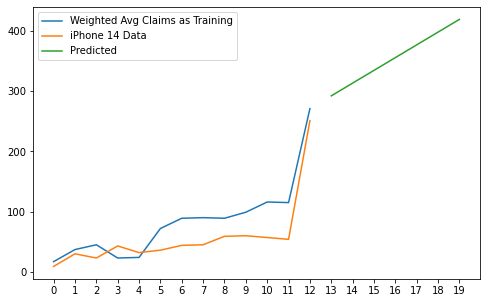

In [22]:
# Based on Professor's suggestion, I can do a testing by removing some of the iPhone 14 data to use it as my test
# This would be better and make more logical sense due to the issue encountered when calcuating error scores below

plt.figure(figsize=(8,5))
plt.plot(final_group['weight_avg_claim'],label="Weighted Avg Claims as Training")
plt.plot(result_iphone_14_copy['claim'],label="iPhone 14 Data")
plt.plot(prediction_weighted,label="Predicted")
plt.legend(loc = 'upper left')
x = [0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17, 18, 19]
plt.xticks(list(range(0,max(x)+1)),[str(i) for i in range(0,max(x)+1)])
plt.show()

# display(result_iphone_14_copy)

In [23]:
# Problem:
# Actually, this doesn't make sense to do this type of score comparison as I can twist the model a bit and it'll still use 
# the initial training data to and the ground truth data to determine the error difference. It has no information on what that
# means for the model and the new changes in model parameters. Thus, the only true way to do it is to subset the iPhone 14 data
# and test on the data to validate it. This will most likely involving doing a 10 data point /4 data point split

# Another issue, if I use the weighted average data that is similar to iPhone 14 data, then it doesn't necessarily tell
# me any new informaiton on iPhone 14 verses when I could have just gone and created a model directly off of the iPhone 14 series
# in the very beginning.

r2_score_val = r2_score(result_iphone_14_copy['claim'], final_group['weight_avg_claim'])

score = np.sqrt(mean_squared_error(result_iphone_14_copy['claim'], final_group['weight_avg_claim']))

print(f' R2 Score: {r2_score_val:0.2f}')

print(f' RMSE Score: {score:0.2f}')

 R2 Score: 0.62
 RMSE Score: 35.55


#### Conducting Manual ARIMA to Change Parameters

/home/leet23/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/leet23/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


13    270.706912
14    288.715391
15    304.045501
16    319.232538
17    333.984028
18    348.347174
19    362.328017
Name: predicted_mean, dtype: float64

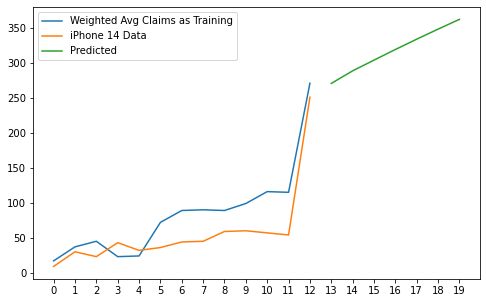

In [24]:
auto_arima_weight2 = ARIMA(final_group['weight_avg_claim'], order=(2,1,1))
auto_arima_weight2 = auto_arima_weight2.fit()

forecast_test_auto = auto_arima_weight2.forecast(7)
# Look at periods 16-19 to see March data predictions
display(forecast_test_auto)

plt.figure(figsize=(8,5))
plt.plot(final_group['weight_avg_claim'],label="Weighted Avg Claims as Training")
plt.plot(result_iphone_14_copy['claim'],label="iPhone 14 Data")
plt.plot(forecast_test_auto,label="Predicted")
plt.legend(loc = 'upper left')
x = [0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17, 18, 19]
plt.xticks(list(range(0,max(x)+1)),[str(i) for i in range(0,max(x)+1)])
plt.show()